<a href="https://colab.research.google.com/github/princessmittens/Train-Cars-Pytorch-/blob/master/PytorchFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

print(torch.__version__)


tcmalloc: large alloc 1073750016 bytes == 0x5797e000 @  0x7f6ecb5ac2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
0.4.1


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
import pandas as pd
from torch.utils.data.dataset import random_split
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

plt.ion()   # interactive mode
isFarshid = False

!wget https://www.dropbox.com/s/xslf1z7185mhfn5/train_corrected.zip?dl=0
!unzip train_corrected.zip?dl=0

# Reading training data 
data = pd.read_csv('train_cars.csv')


--2018-12-16 16:29:36--  https://www.dropbox.com/s/xslf1z7185mhfn5/train_corrected.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/xslf1z7185mhfn5/train_corrected.zip [following]
--2018-12-16 16:29:36--  https://www.dropbox.com/s/raw/xslf1z7185mhfn5/train_corrected.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc025e8f9507b527bc12155b0a4.dl.dropboxusercontent.com/cd/0/inline/AXmaNtCmrd2TQZFXgIRQWGoeG2XDCq4Oix6XDVwoRLNcMMvaJjP-rSDiLrkthTBoC5zRukLeXN2yU-duf7hp7G2MEYFKC_S28itFdvLcXiO7uoO6_4ZnvnhUSOdsXvpRaecXbMuIPuj6WKGBUDcxU8LYRzDKoaJvk7Y3aOOcDeJ1LzpCC_MupG7oFH0c_sqth9o/file [following]
--2018-12-16 16:29:36--  https://ucc025e8f9507b527bc12155b0a4.dl.dropboxusercontent.com/cd/0/inline/AXmaNtCmrd2TQZFXgIRQWGoeG

In [0]:

!pip install Pillow==4.1.0

    100% |████████████████████████████████| 5.7MB 7.2MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.1.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0


In [0]:
# Initial model used from tutorial
import PIL 
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable
from skimage import io, transform
# Simple model used from pytorch tutorials
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 15)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 5 * 5)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# net = Net()

In [0]:
# https://stackoverflow.com/questions/35584085/how-to-count-duplicate-rows-in-pandas-dataframe
# print distribution of the classes in train_cars
class_dist = data.groupby(['target'])['target'].count()
print(class_dist)

target
bus                                 53
cement mixer                        17
crane truck                         16
dedicated agricultural vehicle       5
hatchback                         3080
jeep                               865
light truck                        164
minibus                             25
minivan                            586
pickup                             435
prime mover                         44
sedan                             5783
tanker                               3
truck                              179
van                                362
Name: target, dtype: int64


In [0]:
import os
from PIL import Image

class Train_Cars(Dataset):
#   gets data, if there is no csv (for example a train_split from train/test split, then read the dataset instead)
    def __init__(self, csv_path, root_dir, transform=None, readCsv=False, dataset=data):
        if (readCsv==True):
          self.data = pd.read_csv(csv_path)
        else:
          self.data = dataset 
        self.labels = self.data.target
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
      
#       creates a hashtable to convert class name to int so that it can be transformed into tensor
    def getLabelNo(self, label):
      classNo = {"minivan":0, "sedan": 1, "truck": 2, "jeep":3, "dedicated agricultural vehicle": 4,"hatchback": 5,
                 "cement mixer": 6,"van": 7, "prime mover":8,"crane truck":9, 
                  "light truck":10,"tanker":11, "pickup":12,"minibus": 13, "bus":14}
      return classNo[label]
    
#     Vice versa, gets class name from an int
    def getLabelName(self, number):
      classNames = {0: "minivan", 1: "sedan", 2: "truck", 3: "jeep", 4: "dedicated agricultural vehicle", 5 : "hatchback",
                 6: "cement mixer", 7: "van", 8 : "prime mover", 9: "crane truck", 
                  10 : "light truck", 11 : "tanker", 12: "pickup", 13: "minibus", 14:"bus"}
      return classNames[number]
    
#     transforms gets image and transforms, gets label and converts to tensor
    def __getitem__(self, index):
        img_name = os.path.join(self.root_dir, self.data.iloc[index, 0])   
        image = Image.open(img_name)
        label = self.data.iloc[index, 1]
        labelno = self.getLabelNo(label)
        label = np.asarray(labelno)
        
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [0]:
from sklearn.model_selection import train_test_split

# split and stratify data so that classes are evenly distributed in both datasets; train test valid split is 90: 5: 5
train_split, test_val_split = train_test_split(data, test_size=0.1, stratify=data['target'])
val_split, test_split = train_test_split(test_val_split, test_size=0.5, stratify=test_val_split['target']) 

# # Creating PT data samplers and loaders:
print("Train size is: ", len(train_split))
print("Validation size is: ", len(val_split))
print("Test size is: ", len(test_split))


Train size is:  10455
Validation size is:  581
Test size is:  581


In [0]:
# create a temp dataloader that iterates through the entire dataset to get the mean/std deviaton below and to print out a few cars
pre_transform = transforms.Compose([transforms.Resize((100, 100))])
dataset = Train_Cars(csv_path='train_cars.csv',root_dir='./train/', transform=pre_transform, readCsv = True, dataset=None)

tmp_loader = torch.utils.data.DataLoader(dataset, batch_size=8)


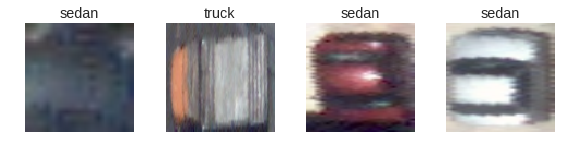

In [0]:
# print out some of the cars in the dataset
for i,(image,label) in enumerate(dataset):
    name = dataset.getLabelName(label.item())

    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title(name)
    plt.imshow(image)
    plt.axis('off')
    if (i==3):
     plt.show()
     break

In [0]:

# get the averages/std of each channel
r = []
g = []
b = []
mean_list = []
std_list = []
total = 0

# can take a few mins to run, has to parse through all pixels and then average channels for each one
for (image,label) in dataset:

    pixels = list(image.getdata())
    rgb_mean = np.array(pixels).mean(axis=0)
    rgb_std = np.array(pixels).std(axis=0)
    mean_list.append(rgb_mean)
    std_list.append(rgb_std)
    total += 1

#  get final mean/std values summed for dataset    
img_mean = np.array(mean_list).mean(axis=0)
img_std = np.array(std_list).std(axis=0)
print("--- Dataset standard deviation/means for RGB channels ---")
print("R mean: {:.4f}".format(R_mean = float(img_mean[0]/255)))
print("G mean: {:.4f}".format(G_mean = float(img_mean[1]/255)))
print("B mean: {:.4f}".format(B_mean = float(img_mean[2]/255)))
print("R std: {:.4f}".format(R_std = float(img_std[0]/255)))
print("G std: {:.4f}".format(G_std = float(img_std[1]/255)))
print("B std: {:.4f}".format(B_std = float(img_std[2]/255)))


# R_mean= 0.4957
# G_mean= 0.5150
# B_mean= 0.5683
# R_std= 0.0662
# G_std= 0.0704
# B_std= 0.0658

In [0]:
# create new transform with updated normlaized numbers
norm_transform = transforms.Compose([
            transforms.Resize((120, 120)),
            transforms.Pad(4,0),
            transforms.RandomRotation(degrees = 90),
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(100),
            transforms.ToTensor(),
          transforms.Normalize([R_mean, G_mean,B_mean], [R_std, 
                                                G_std, B_std])])


# create train/valid transform
test_valid_transform = transforms.Compose([
            transforms.Resize((120, 120)),
            transforms.Pad(4,0),
            transforms.CenterCrop(100),
            transforms.ToTensor(),
          transforms.Normalize([R_mean, G_mean,B_mean], [R_std, 
                                                G_std, B_std])])

# get training data
train = Train_Cars(csv_path='train_cars.csv', root_dir='./train/', transform=norm_transform, readCsv= False, dataset=train_split)
train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)

# get validation data
valid = Train_Cars(csv_path='train_cars.csv',root_dir='./train/', transform = test_valid_transform, readCsv= False, dataset=val_split)
validation_loader = torch.utils.data.DataLoader(valid, batch_size=64, shuffle=False)

# get test data
test = Train_Cars(csv_path='train_cars.csv', root_dir='./train/', transform = test_valid_transform, readCsv= False, dataset=test_split)
test_loader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=False)


Sample of transformed image from train dataset and the label


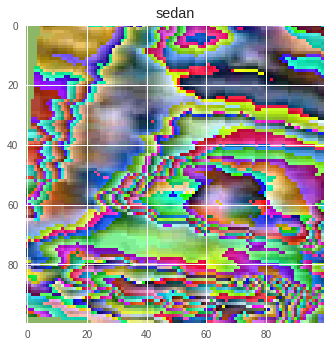

Sample of transformed image from valid dataset and the label


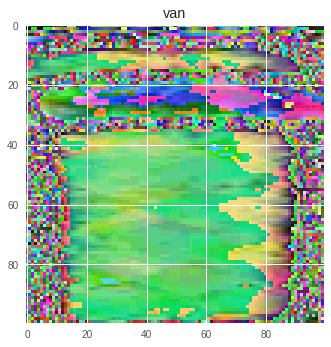

In [0]:
print("Sample of transformed image from train dataset and the label")
to_pil = torchvision.transforms.ToPILImage()
img = to_pil(train.__getitem__(0)[0])
image, label = train.__getitem__(0)
name = train.getLabelName(label.item())
plt.title(name)
plt.imshow(img)
plt.show()

print("Sample of transformed image from valid dataset and the label - Simple transformations were applied")
to_pil = torchvision.transforms.ToPILImage()
img = to_pil(valid.__getitem__(0)[0])
image, label = valid.__getitem__(0)
name = train.getLabelName(label.item())
plt.title(name)
plt.imshow(img)
plt.show()

In [0]:
# function to get test accuracy
def get_test_or_val(dataloader, model):
  model.train(False)
  correct = 0
  total = 0
  final_loss = 0
  final_acc = 0
  running_loss=0
  with torch.no_grad():
    for index, (image,label) in enumerate(dataloader):
          label = label.cuda()
          image = image.cuda()
          image = Variable(image)
          label = Variable(label)
          outputs = model(image)
          _, predicted = torch.max(outputs, 1)
          loss = criterion(outputs, label)
          total += label.size(0)
          correct += (predicted == label.data).double().sum().item()
          running_loss += loss.item()* image.size(0)

  final_loss = running_loss / total
  final_acc = (100*(correct/total))
  return model, final_acc, final_loss

In [0]:
import torchvision.models as models
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

def initialize_resnet18(num_classes):
    model = models.resnet18(pretrained=False)
    num_ftrs = model.fc.in_features
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    model.fc = nn.BatchNorm2d(num_ftrs, track_running_stats=False)
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

def initialize_resnet50(num_classes):
    model = models.resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    model.fc = nn.BatchNorm2d(num_ftrs, track_running_stats=False)
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model  
  
def initialize_alexnet(num_classes):
    model = models.alexnet(pretrained=False)
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs,num_classes)
    return model
  
  

In [0]:

# initialize model
model = initialize_resnet50(15)
# model = initialize_resnet18(15)
# model = initialize_alexnet(15)

#  initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.RMSprop(params_to_update, lr=0.001)

# weights = [0.5, 0.1, 0.5, 0.5, 1, 0.5,
#                  1, 1, 1, 1, 
#                   1, 1, 0.5, 1, 1]
# class_weights = torch.FloatTensor(weights).cuda()
criterion = torch.nn.CrossEntropyLoss()

# loss function
# scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)



In [0]:

# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
import copy
num_epochs = 70

train_acc_history=[]
train_loss_history=[]
valid_acc_history=[]
valid_loss_history=[]
best_val_acc = 0
model.cuda()
if (isFarshid == False):
 for epoch in range(num_epochs):   
    total = 0
    first_run=False
    running_loss=0
    correct = 0
    train_acc = 0
    train_loss = 0
    train_acc = 0
    model.train()
    
    for index, (image, label) in enumerate(train_loader):
      
      image = image.cuda()
      label = label.cuda()
      image = Variable(image)
      label = Variable(label)
      optimizer.zero_grad()
      with torch.set_grad_enabled(True):
        outputs = model(image)
        loss = criterion(outputs, label)
        _, predicted = torch.max(outputs.data, 1)
        loss.backward()
        optimizer.step()
        total += label.size(0)
        correct += (predicted == label.data).double().sum().item()
        running_loss += loss.item()* image.size(0)
    
    train_acc = (100 * (correct/total))
    train_loss = running_loss / total
#     validation
    correct = 0
    total = 0
    final_loss = 0
    final_acc = 0
    running_loss=0
    model.eval()
    with torch.no_grad():
      for index, (image,label) in enumerate(validation_loader):
          optimizer.zero_grad()
          label = label.cuda()
          image = image.cuda()
          image = Variable(image)
          label = Variable(label)
          outputs = model(image)
          loss = criterion(outputs, label)
          _, predicted = torch.max(outputs, 1)
          total += label.size(0)
          correct += (predicted == label.data).double().sum().item()
          running_loss += loss.item()* image.size(0)

    val_loss = running_loss / total
    val_acc = (100*(correct/total))
    print('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {:.2f}%, Valid Accuracy: {:.2f}%, Loss: {:.4f},'
            .format(epoch+1, num_epochs, train_loss, train_acc, val_acc, val_loss))
    train_acc_history.append(train_acc) 
    valid_loss_history.append(val_loss)
    train_loss_history.append(train_loss)
    valid_acc_history.append(val_acc)
    
    if (val_acc > best_val_acc):
      best_val_acc = val_acc
      torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'resnet50.pt')

Epoch [1/70], Loss: 1.4716, Train Accuracy: 51.51%, Valid Accuracy: 56.45%, Loss: 1.2928,
Epoch [2/70], Loss: 1.2768, Train Accuracy: 55.60%, Valid Accuracy: 59.72%, Loss: 1.1866,
Epoch [3/70], Loss: 1.2413, Train Accuracy: 57.24%, Valid Accuracy: 57.66%, Loss: 1.2070,
Epoch [4/70], Loss: 1.1955, Train Accuracy: 58.62%, Valid Accuracy: 62.82%, Loss: 1.0907,
Epoch [5/70], Loss: 1.1505, Train Accuracy: 59.76%, Valid Accuracy: 62.13%, Loss: 1.1186,
Epoch [6/70], Loss: 1.1135, Train Accuracy: 60.83%, Valid Accuracy: 65.40%, Loss: 1.0079,
Epoch [7/70], Loss: 1.0658, Train Accuracy: 62.22%, Valid Accuracy: 65.58%, Loss: 1.0015,
Epoch [8/70], Loss: 1.0355, Train Accuracy: 63.70%, Valid Accuracy: 64.72%, Loss: 1.0068,
Epoch [9/70], Loss: 1.0233, Train Accuracy: 64.12%, Valid Accuracy: 60.41%, Loss: 1.0650,
Epoch [10/70], Loss: 1.0043, Train Accuracy: 64.31%, Valid Accuracy: 65.40%, Loss: 1.0112,
Epoch [11/70], Loss: 1.0515, Train Accuracy: 62.71%, Valid Accuracy: 63.86%, Loss: 1.0297,
Epoch [1

In [0]:
# Function to plot accuracy curves/loss functions 
def plot_curve(array, legend, title, val_array=None, val_legend=None, y_axis=None, ymax=None):
  val_hist = []
  ahist = []
  num_epochs = 70
  plt.title(title)
  plt.xlabel("Training Epochs")
  plt.ylabel(legend)
  plt.style.use('ggplot')
  val_hist = [(float(i)) for i in val_array]  
  train_hist = [(float(i)) for i in array]
  if (val_array is not None):
    plt.ylabel(y_axis)
    val_hist = [(float(j)) for j in val_array]
    plt.plot(range(1,num_epochs+1),val_hist,label=val_legend)
    
  plt.plot(range(1,num_epochs+1),train_hist,label=legend)
  if (ymax is not None):
    plt.ylim((0,ymax))
  plt.xticks(np.arange(0, num_epochs, 10))
  plt.legend()
  plt.show()
  

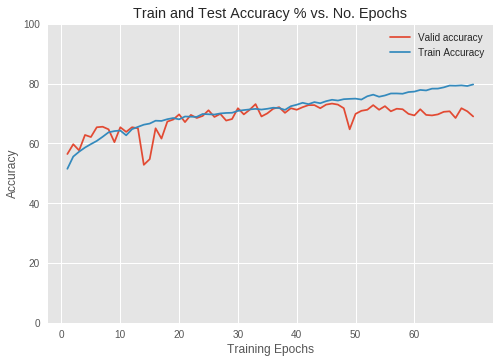

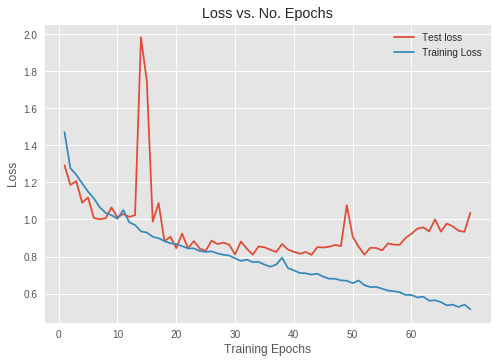

In [0]:
# Plot loss and accuracy curves
plot_curve(train_acc_history, "Train Accuracy", "Train and Test Accuracy % vs. No. Epochs", valid_acc_history, "Valid accuracy", "Accuracy", 100)
plot_curve(train_loss_history, "Training Loss", "Loss vs. No. Epochs", valid_loss_history, "Test loss", "Loss")

In [0]:
# resnet = models.resnet50(pretrained=False)
# num_ftrs = model.fc.in_features
# resnet.avgpool = nn.AdaptiveAvgPool2d(1)
# resnet.fc = nn.Linear(num_ftrs, 15)
# resnet.load_state_dict(torch.load('resnet18.pt'))
# resnet.cuda()
# model, acc, loss = get_test_or_val(test_loader, resnet)
# print("Final accuracy for the resnet18 model is {:.2f}%".format(acc))
# print("Loss is {:.4f}%".format(loss))


In [0]:
resnet = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
resnet.avgpool = nn.AdaptiveAvgPool2d(1)
resnet.fc = nn.Linear(num_ftrs, 15)

checkpoint = torch.load('resnet50.pt')
resnet.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

resnet.cuda()
model, acc, loss = get_test_or_val(test_loader, resnet)
print("Final accuracy for the resnet50 model is {:.2f}%".format(acc))
print("Loss is {:.4f}%".format(loss))


Final accuracy for the resnet50 model is 68.33%
Loss is 0.9009%


In [0]:
# # from google.colab import files
# # files.download("resnet50.pt") 

# from google.colab import files
# files.download("resnet.pt") 

In [0]:
# alexnet = models.alexnet(pretrained=False)
# num_ftrs = model.classifier[6].in_features
# alexnet.classifier[6] = nn.Linear(num_ftrs,15)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# checkpoint = torch.load('alexnet1.pt')
# alexnet.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# alexnet.cuda()
# model, acc, loss = get_test_or_val(test_loader, alexnet)
# print("Final accuracy for the resnet18 model is {:.2f}%".format(acc))
# print("Loss is {:.4f}%".format(loss))